##### Copyright 2018 The TensorFlow Authors.
Released under the Apache 2.0 open source license. Esta modificado por el autor y con distintas imágenes. Obtenido de los tutoriales de Tensorflow: https://www.tensorflow.org/tutorials/generative/style_transfer?hl=es-419

# Transferencia de estilo neuronal + La I.A. Interpreta Las Meninas de Picasso con el estilo de Velázquez

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

En 1957 Pablo Picasso realizó 58 pinturas de análisis exhaustivo y reinterpretando varias veces Las Meninas de Diego Velázquez.

Se atribuye a Picasso este comentario dirigido a Sabartés en 1950:

"Si alguien se pusiese a copiar Las Meninas, totalmente con buena fe, al llegar a cierto punto y si el que las copiara fuera yo, diría: ¿Y si pusiera esta un poquito más a la derecha o a la izquierda? Yo probaría de hacerlo a mi manera, olvidándome de Velázquez. La prueba me llevaría de seguro a modificar la luz o a cambiarla, con motivo de haber cambiado de lugar algún personaje. Así, poco a poco, iría pintando unas Meninas que serían detestables para el copista de oficio, pero serían mis Meninas." Picasso, 1950.

Hoy el aprendizaje profundo, que posibilita componer una imagen con el estilo de otra imagen, lo llamamos transferencia de estilo neural, nos permite continuar la historia:

Ahora el algoritmo neural reinterpreta Las Meninas de Picasso con el estilo de Diego Velázquez. Esta es la mitad de la historia que se esconde en la portada de este libro. (la otra imagen de la portada es la reinterpretación de las Meninas de Velázquez con el estilo de Picasso, también por la I.A.)

La transferencia de estilo neuronal es la técnica que se describe en "A Neural Algorithm of Artistic Style" (Gatys et al.).

Nota: El algoritmo de transferencia de estilo original, optimiza el contenido de la imagen a un estilo particular. Los enfoques modernos entrenan un modelo para generar la imagen estilizada directamente (similar a Cyclegan ) con un modelo de estilización de imagen arbitraria preentrenado de TensorFlow Hub.

La transferencia de estilo neuronal es una técnica de optimización utilizada para tomar dos imágenes, una imagen de contenido y una imagen de referencia de estilo y combinarlas para que la imagen de salida se vea como la imagen de contenido, pero "pintada". en el estilo de la imagen de referencia de estilo.

Esto se implementa mediante la optimización de la imagen de salida para que coincida con las estadísticas de contenido de la imagen de contenido y las estadísticas de estilo de la imagen de referencia de estilo. Estas estadísticas se extraen de las imágenes utilizando una red convolucional.


Por ejemplo utilizaremos la imagen del cuadro Las Meninas de Picasso para estilizarla con el original.

<img src="mp.jpg" width="500px"/>

Ahora utilizaremos la pintura original de Velázquez, como imagen de estilo.

<img src="mv.jpg" width="500px"/>


Este es el resultado: Las Meninas de Picasso reinterpretadas con el estilo de Velázquez por el algoritmo neuronal. Véamos la técnica:

<img src="styd-image.png" style="width: 500px;"/>

## Setup


### Importar y configurar módulos

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Importamos imágenes:

In [4]:
content_path = 'mp.jpg'
style_path = 'mv.jpg'

## Visualizar las entradas

Define una funcion para cargar las imágenes y limita su dimensión a 512 pixels.

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Creamos una función simple para mostrar las imágenes:

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

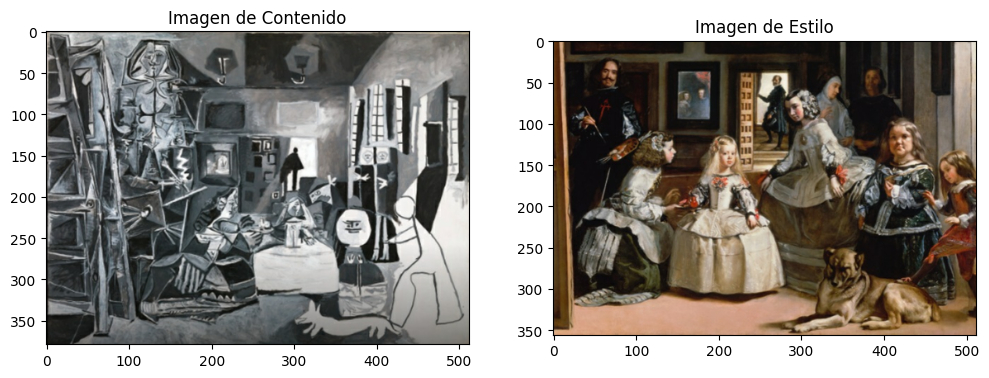

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Imagen de Contenido')

plt.subplot(1, 2, 2)
imshow(style_image, 'Imagen de Estilo')

## Transferencia de estilo rápida usando TF-Hub

Este tutorial nos explica el algoritmo de transferencia de estilo, que optimiza el contenido de la imagen a un estilo particular. Antes de entrar en detalles, veamos cómo [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) hace esto:

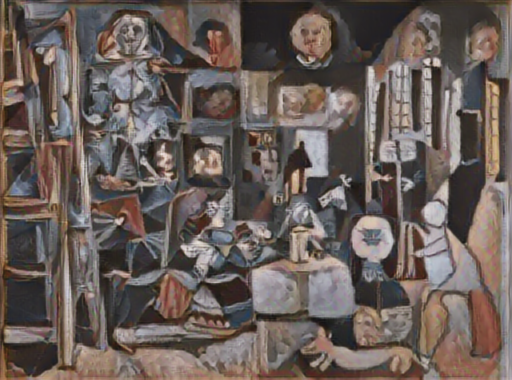

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Definir las representaciones de contenido y estilo.

Comprobamos que el resultado del agorithmo crea mucho ruido y distorsiones en la imagen resultante. Vamos a tratar que el Machine Learning, nos ayude.
Para ello, utilizamos las capas intermedias del modelo y así obtener las representaciones de *contenido* y *estilo* de la imagen. 

A partir de la capa de entrada de la red, las primeras activaciones de capa representan características de bajo nivel como bordes y texturas. A medida que avanza por la red, las últimas capas representan características de nivel superior: partes de objetos como *ruedas* u *ojos*. En este caso, está utilizando la arquitectura de red VGG19, una red de clasificación de imágenes previamente entrenada. 

Estas capas intermedias son necesarias para definir la representación del contenido y el estilo de las imágenes. Para una imagen de entrada, intentamos hacer coincidir el estilo correspondiente y las representaciones de destino del contenido en estas capas intermedias.


Cargamos el VGG19 y los probamos en nuestra imagen para asegurarnos que funciona correctamente:

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[("carpenter's_kit", 0.12522455),
 ('ladle', 0.107124835),
 ('spatula', 0.10051496),
 ('shovel', 0.07512524),
 ('cleaver', 0.05470718)]

Ahora cargamos un VGG19 sin el encabezado de clasificación y que enumere los nombres de las capas, para identificarlas.

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Usaremos la capa intermedia block5_conv2, para reinterpretar el contenido con el estilo:


In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Capas intermedias para estilo y contenido.

¿Por qué estos resultados intermedios dentro de nuestro algoritmo de imágenes previamente entrenado nos permiten definir representaciones de estilo y contenido?

En un nivel alto, para que una red realice la clasificación de imágenes (para lo cual esta red ha sido entrenada), debe comprender la imagen. Esto requiere tomar la imagen sin procesar como píxeles de entrada y construir una representación interna que convierta los píxeles de la imagen, sin procesar, en una comprensión compleja de las características presentes en la imagen.

Esta es también una razón por la que las redes neuronales convolucionales pueden generalizarse bien: pueden capturar las invariancias y las características definitorias dentro de clases (por ejemplo, gatos frente a perros) que son independientes del ruido de fondo y otras molestias. Por lo tanto, en algún lugar entre el lugar donde la imagen sin procesar se introduce en el modelo y la etiqueta de clasificación de salida, el modelo sirve como un extractor de características complejas. Al acceder a capas intermedias del modelo, puede describir el contenido y el estilo de las imágenes de entrada.

## Construimos el Modelo

Las redes en `tf.keras.applications` están diseñadas para que pueda extraer fácilmente los valores de la capa intermedia utilizando la API funcional de Keras.

Para definir un modelo utilizando la API funcional, debemos especificar las entradas y salidas:

`modelo = Modelo (entradas, salidas)`

La siguiente función construye un modelo VGG19 que devuelve una lista de salidas de la capa intermedia:

In [13]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Y para crear el modelo:

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 356, 512, 64)
  min:  0.0
  max:  794.3546
  mean:  20.837217

block2_conv1
  shape:  (1, 178, 256, 128)
  min:  0.0
  max:  3195.6028
  mean:  123.546104

block3_conv1
  shape:  (1, 89, 128, 256)
  min:  0.0
  max:  9194.047
  mean:  131.32794

block4_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  17718.174
  mean:  483.2285

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  2778.7576
  mean:  41.757538



## Calcular el estilo

El contenido de una imagen está representado por los valores de los mapas de características intermedias.

Resulta que el estilo de una imagen se puede describir mediante los medias y las correlaciones entre los diferentes mapas de características. 

Calculamos la matriz de Gram, que incluye esta información, tomando el producto externo del vector de características consigo mismo en cada ubicación y promediando ese producto externo en todas las ubicaciones. Esta matriz de Gram se puede calcular para una capa particular como:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Podemos implementarlo de manera concisa usando la función `tf.linalg.einsum`:

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraemos el estilo y el contenido


Construimos el modelo que devuelve los tensores de estilo y contenido.

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Cuando llamamos a una imagen, este modelo devuelve la matriz de Gram (estilos) con los `style_layers` y  del contenido del `content_layers`:

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0008357624
    max:  19523.576
    mean:  599.1858

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  166169.92
    mean:  22909.438

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  395286.94
    mean:  21483.506

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6821322.0
    mean:  243976.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  77157.06
    mean:  1388.6733

Contents:
   block5_conv2
    shape:  (1, 23, 32, 512)
    min:  0.0
    max:  1393.8965
    mean:  13.327562


## Ejecutar descenso de gradiente

Con este extractor de estilo y contenido, ahora podemos implementar el algoritmo de transferencia de estilo. Lo hacemos calculando el error cuadrático medio de la salida de su imagen en relación con cada objetivo, luego tomamos la suma ponderada de estas pérdidas.

Establecemos sus valores objetivo de estilo y contenido:

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Definimos una `tf.Variable` para contener la imagen a optimizar. Para que esto sea rápido, lo iniciamos con la imagen del contenido (la `tf.Variable` debe tener la misma forma que la imagen del contenido):

In [19]:
image = tf.Variable(content_image)

Dado que se trata de una imagen con formato float, definimos una función para mantener los valores de píxeles entre 0 y 1:

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Creamos el optimizador. El documento recomienda LBFGS, pero Adam también funciona bien:

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Para optimizar, utilizamos una combinación ponderada de las dos pérdidas para obtener la pérdida total:

In [22]:
style_weight=1e-2
content_weight=1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Usamos `tf.GradientTape` para actualizar la imagen.

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Ahora ejecutamos unos pocos pasos para hacer una prueba:

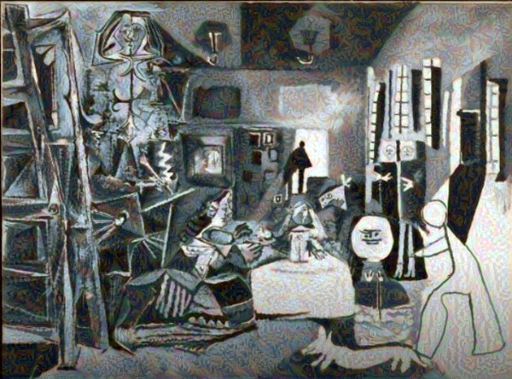

In [25]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [26]:
file_name = 'styd1-image.png'
tensor_to_image(image).save(file_name)

Ya que está funcionando, realizaremos la optimización más larga:

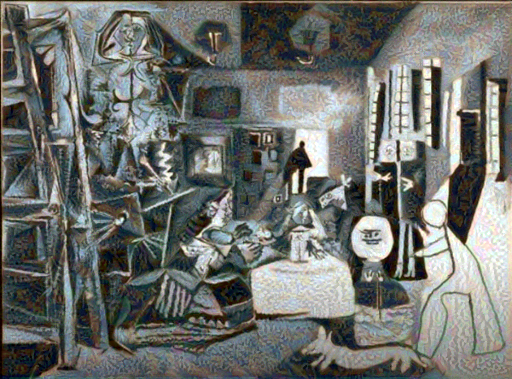

Train step: 3
Total time: 53.2


In [27]:
import time
start = time.time()

epochs = 10 #10
steps_per_epoch = 100 #100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [28]:
file_name = 'styd1-image2.png'
tensor_to_image(image).save(file_name)

## Variación total de la pérdida

Una desventaja de esta implementación básica es que produce muchos artefactos de alta frecuencia. Lo podemos mejorar utilizando un término de regularización explícito en los componentes de alta frecuencia de la imagen. En transferencia de estilo esto se denomina *pérdida total de variación*:

In [29]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

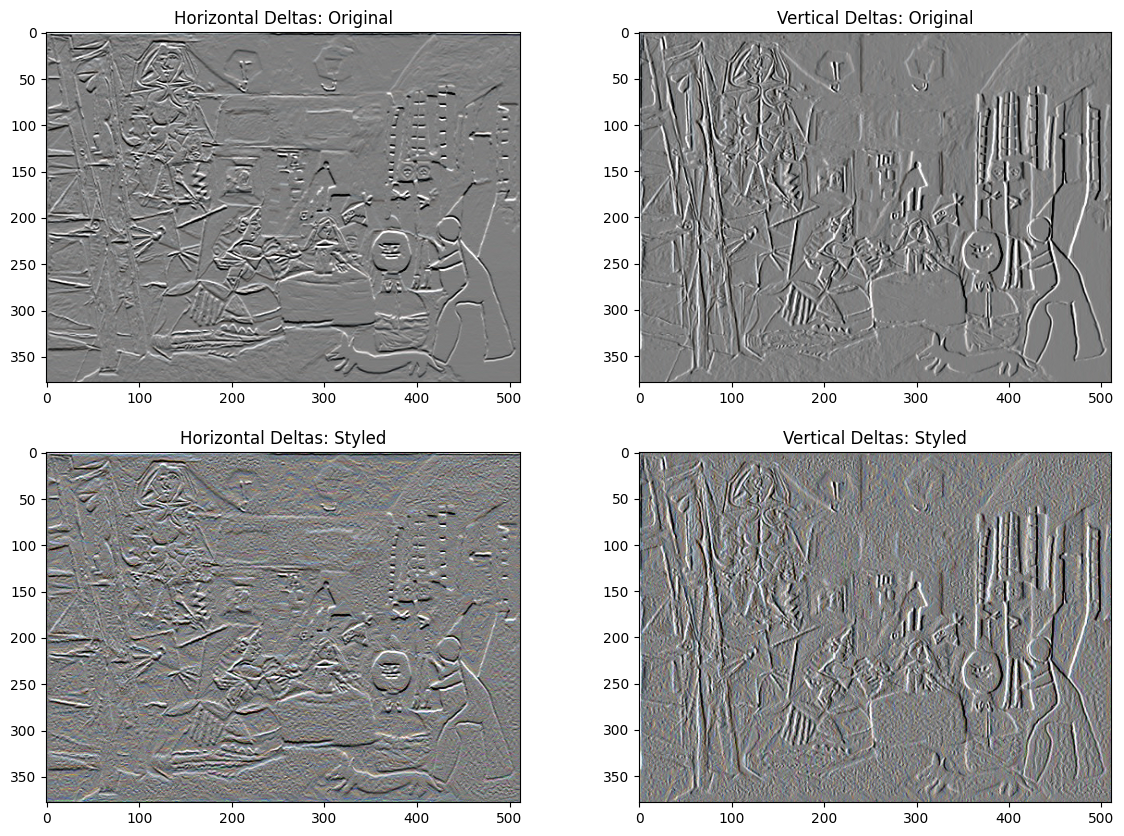

In [30]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Esto muestra cómo los componentes de alta frecuencia han aumentado.

Además, este componente de alta frecuencia es básicamente un detector de bordes. Puede obtener resultados similares del detector de bordes de Sobel, por ejemplo:

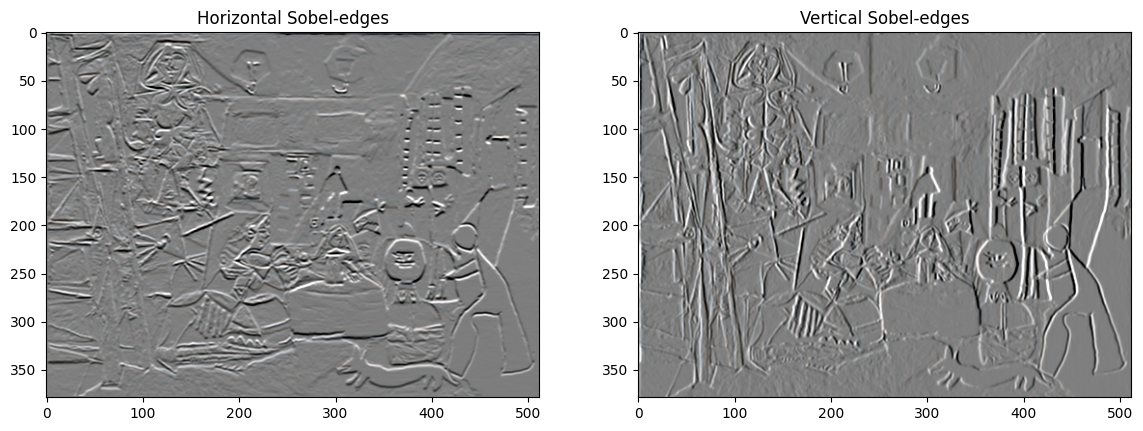

In [31]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

La pérdida de regularización asociada a esto es la suma de los cuadrados de los valores:

In [32]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [33]:
total_variation_loss(image).numpy()

61973.332

Eso demostra lo que hace. Pero no es necesario que lo implementemos nosostros, TensorFlow incluye una implementación estándar:

In [34]:
tf.image.total_variation(image).numpy()

array([61973.332], dtype=float32)

## Vuelvemos a ejecutar la optimización

Elegimos un peso `total_variation_loss`:

In [35]:
total_variation_weight=30

Ahora incluimos la función `train_step`:

In [36]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reiniciamos la variable de imagen y el optimizador:

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

Y ejecutamos la optimizacion:

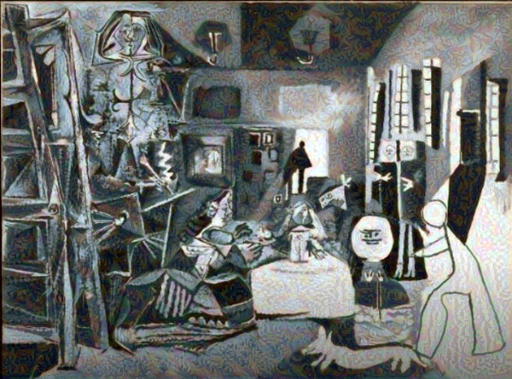

Train step: 3
Total time: 58.2


In [38]:
import time
start = time.time()

epochs = 10 #10
steps_per_epoch = 100 #100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finalmente, guardamos el resultado:

In [39]:

file_name = 'styd-image.png'
tensor_to_image(image).save(file_name)


## Aprender más 

Este tutorial demuestra el algoritmo de transferencia de estilo original. Para una aplicación sencilla de transferencia de estilo, consultar en: [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) para obtener más información sobre cómo utilizar el modelo de transferencia de estilo de imagen arbitraria de [TensorFlow Hub](https://tfhub.dev).